In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 100,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9506172839506173, Loss: 0.19028040214821143
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.168333371480306
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.15398587120903862
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.14382983137060096
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.14100800620185006


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.98099124 0.01563918 0.00336963]
[1. 0. 0.] <-> [0.9565538  0.03081269 0.01263354]
[1. 0. 0.] <-> [0.9492999  0.03424746 0.01645261]
[0. 0. 1.] <-> [0.07045717 0.00813929 0.9214035 ]
[1. 0. 0.] <-> [0.9795125  0.01143506 0.00905231]
[1. 0. 0.] <-> [0.9751473  0.01545822 0.00939448]
[0. 0. 1.] <-> [0.63824046 0.0103204  0.35143918]
[1. 0. 0.] <-> [0.6656304  0.3289632  0.00540637]
[0. 1. 0.] <-> [7.3611706e-02 9.2553544e-01 8.5291272e-04]
[1. 0. 0.] <-> [0.95447826 0.01831157 0.02721005]
[0. 1. 0.] <-> [0.55225563 0.44557467 0.00216969]
[1. 0. 0.] <-> [0.9401594  0.05407729 0.00576325]
[1. 0. 0.] <-> [0.9700734  0.02043143 0.00949516]
[1. 0. 0.] <-> [0.9755986  0.01906233 0.0053391 ]
[1. 0. 0.] <-> [0.9807022  0.00698813 0.01230967]
[0. 1. 0.] <-> [1.4624158e-01 8.5301650e-01 7.4195262e-04]
[1. 0. 0.] <-> [0.97939235 0.00617743 0.01443031]
[1. 0. 0.] <-> [0.9507837  0.04180211 0.00741413]
[1. 0. 0.] <-> [0.9625729  0.03092708 0.00650003]
[0. 0. 1.] <-> [0.05875799 0.007

In [12]:
# Testing Performance

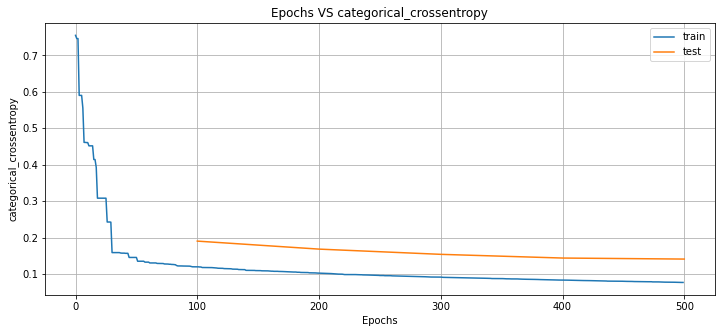

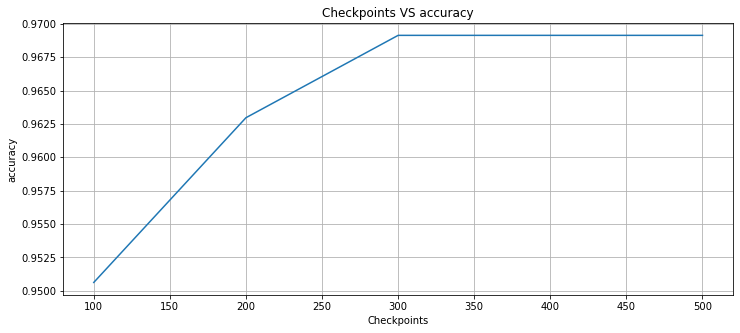

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9506172839506173, 'mean_square_error': 0.09957813819636749, 'categorical_crossentropy': 0.19028040214821143, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 7, 'tn_hit': 23, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.08232933063409004, 'categorical_crossentropy': 0.168333371480306, 'precision': 0.9444444444444444, 'recall': 0.9444444444444444, 'f1': 0.9444444444444444, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 5, 'tn_hit': 25, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 2}, 2: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.0751568901472863, 'categorical_crossentropy': 0.15398587120903862, 'precisio

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.971001   -2.919831   -2.3559237   2.5230396   0.23690689]
 bias: -1.4155452251434326

Neuron 1: weights:
[-2.315567   3.         3.         1.8559376 -1.7511096]
 bias: -2.7078611850738525

Neuron 2: weights:
[-0.15116581  2.3309362   1.0835975  -0.7983745  -1.9973061 ]
 bias: 2.3113486766815186

Neuron 3: weights:
[ 0.20469993 -0.09761599 -1.8265308  -2.7950153  -0.362022  ]
 bias: -1.6165761947631836

$
Layer 2
Neuron 0: weights:
[ 0.42076698 -3.          2.0208545   2.9116964 ]
 bias: -1.3413212299346924

Neuron 1: weights:
[-2.1080728  3.        -1.954365   1.3112713]
 bias: -0.617047905921936

Neuron 2: weights:
[ 3.         -2.7518756  -3.         -0.04814354]
 bias: -0.7841291427612305

$

